In [1]:
# For classic ML models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# For deep learning models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder


In [2]:
# Load the dataset
data = pd.read_csv('data_cleaned.csv')

# Display the first few rows to understand the structure
data.head()

,Unnamed: 0,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,342,0,0,0,4.0,0.0,0,1,9.0,0,...,1.60,71.67,27.99,0,0,1,1,0,0,0
1,343,0,1,0,0.0,0.0,0,1,6.0,0,...,1.78,95.25,30.13,0,0,1,1,1,0,0
2,345,0,1,0,0.0,0.0,0,0,8.0,1,...,1.85,108.86,31.66,1,0,0,1,2,0,1
3,346,0,0,1,5.0,0.0,0,1,9.0,0,...,1.70,90.72,31.32,0,0,1,1,2,0,1
4,347,0,0,2,3.0,15.0,0,1,5.0,2,...,1.55,79.38,33.07,0,0,1,1,2,0,0


In [3]:
corr = data.corr()
strong_correlation_cols = [col for col in corr.columns if corr.loc['HadHeartAttack', col] >= 0.05 and col != 'HadHeartAttack']

# Select features (X) and target (y)
X = data[strong_correlation_cols]
y = data['HadHeartAttack']

strong_correlation_cols

['Sex',
 'GeneralHealth',
 'PhysicalHealthDays',
 'RemovedTeeth',
 'HadAngina',
 'HadStroke',
 'HadCOPD',
 'HadKidneyDisease',
 'HadArthritis',
 'HadDiabetes',
 'DeafOrHardOfHearing',
 'BlindOrVisionDifficulty',
 'DifficultyConcentrating',
 'DifficultyWalking',
 'DifficultyDressingBathing',
 'DifficultyErrands',
 'ChestScan',
 'AgeCategory',
 'PneumoVaxEver']

In [4]:
# 检查并将映射后的列转换为整数类型
for col in data.columns:
    if data[col].dtype == 'object':
        print(f"Warning: Column {col} is still of type 'object'. Attempting to convert.")
    # 尝试将列转换为整数类型
    data[col] = data[col].astype('int', errors='ignore')

# 特征列（X）和目标列（y）
#X = data.drop('HadHeartAttack', axis=1)
X = data[strong_correlation_cols]
y = data['HadHeartAttack'].astype('int')  # 确保目标变量是整数类型


In [9]:
x=data[strong_correlation_cols]
y=data['HadHeartAttack']

from imblearn.over_sampling import SMOTE

resampler = SMOTE()
x,y = resampler.fit_resample(x,y)

In [10]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 输出训练集和测试集的形状
print("训练集特征形状:", X_train.shape)
print("测试集特征形状:", X_test.shape)
print("训练集目标形状:", y_train.shape)
print("测试集目标形状:", y_test.shape)

训练集特征形状: (372124, 19)
测试集特征形状: (93032, 19)
训练集目标形状: (372124,)
测试集目标形状: (93032,)


In [11]:
# 模型评估函数
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # 生成混淆矩阵和分类报告
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, zero_division=1)

    # 输出结果
    print(f'{model_name} Accuracy: {accuracy:.2f}')
    print(f'{model_name} Classification Report:\n{class_report}')

    # 绘制混淆矩阵
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Heart Disease', 'Heart Disease'])
    disp.plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # 计算 AUC-ROC
    if hasattr(model, "predict_proba"):
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print(f"{model_name} AUC-ROC: {roc_auc:.2f}")

    return accuracy

In [12]:
# 绘制 PR 曲线
def plot_pr_curve(model, X_test, y_test, model_name):
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    plt.plot(recall, precision, label=f"{model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for {model_name}")
    plt.legend()
    plt.show()

Epoch 1/30 - Train Loss: 0.5070 - Test Loss: 0.4764 - Train Acc: 0.7484 - Test Acc: 0.7667
Epoch 2/30 - Train Loss: 0.4753 - Test Loss: 0.4705 - Train Acc: 0.7656 - Test Acc: 0.7687
Epoch 3/30 - Train Loss: 0.4685 - Test Loss: 0.4656 - Train Acc: 0.7699 - Test Acc: 0.7721
Epoch 4/30 - Train Loss: 0.4642 - Test Loss: 0.4635 - Train Acc: 0.7732 - Test Acc: 0.7731
Epoch 5/30 - Train Loss: 0.4610 - Test Loss: 0.4587 - Train Acc: 0.7757 - Test Acc: 0.7781
Epoch 6/30 - Train Loss: 0.4592 - Test Loss: 0.4577 - Train Acc: 0.7768 - Test Acc: 0.7785
Epoch 7/30 - Train Loss: 0.4575 - Test Loss: 0.4627 - Train Acc: 0.7778 - Test Acc: 0.7747
Epoch 8/30 - Train Loss: 0.4561 - Test Loss: 0.4556 - Train Acc: 0.7789 - Test Acc: 0.7794
Epoch 9/30 - Train Loss: 0.4549 - Test Loss: 0.4550 - Train Acc: 0.7796 - Test Acc: 0.7797
Epoch 10/30 - Train Loss: 0.4538 - Test Loss: 0.4528 - Train Acc: 0.7807 - Test Acc: 0.7805
Epoch 11/30 - Train Loss: 0.4529 - Test Loss: 0.4527 - Train Acc: 0.7810 - Test Acc: 0.78

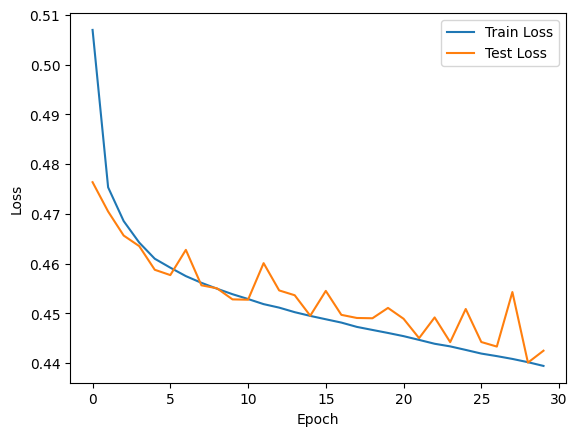

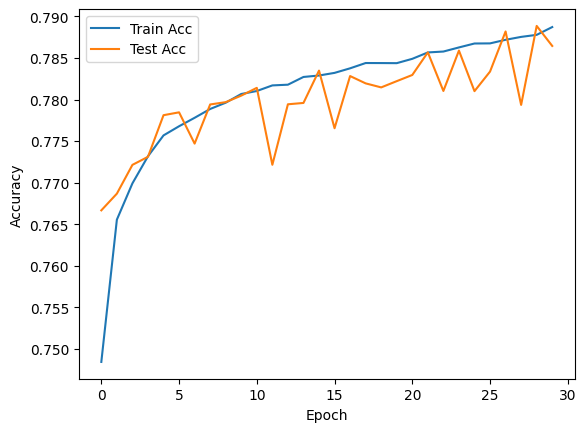

Test Accuracy: 0.7864
Confusion Matrix:
[[37176  9323]
 [10544 35989]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     46499
           1       0.79      0.77      0.78     46533

    accuracy                           0.79     93032
   macro avg       0.79      0.79      0.79     93032
weighted avg       0.79      0.79      0.79     93032

ROC AUC: 0.8749


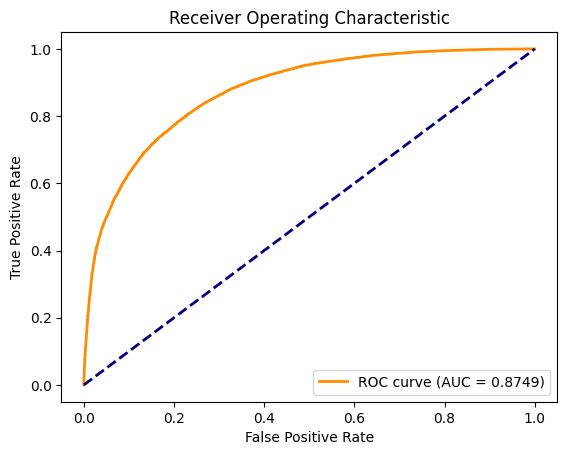

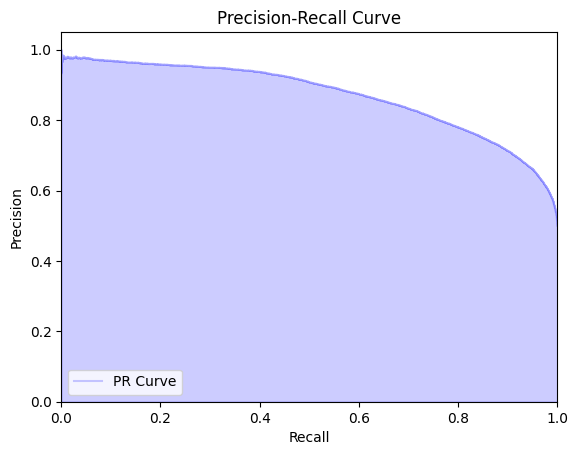

Confusion Matrix:
[[37176  9323]
 [10544 35989]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     46499
           1       0.79      0.77      0.78     46533

    accuracy                           0.79     93032
   macro avg       0.79      0.79      0.79     93032
weighted avg       0.79      0.79      0.79     93032



In [13]:
from sklearn.metrics import roc_curve, auc

class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size):
        super(HeartDiseaseModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        #self.leaky_relu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        #x = self.leaky_relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        #x = self.leaky_relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        #x = self.leaky_relu(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

# 定义训练函数
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            predicted_train = (output > 0.5).float()
            total_train += target.size(0)
            correct_train += (predicted_train == target).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                loss = criterion(output, target)
                running_test_loss += loss.item()
                predicted_test = (output > 0.5).float()
                total_test += target.size(0)
                correct_test += (predicted_test == target).sum().item()

        test_loss = running_test_loss / len(test_loader)
        test_accuracy = correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f} - "
              f"Train Acc: {train_accuracy:.4f} - Test Acc: {test_accuracy:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    y_prob = []  # 用于存储预测概率

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            predicted = (output > 0.5).float()
            total += target.size(0)
            correct += (predicted == target).sum().item()

            y_prob.extend(output.cpu().numpy())  # 记录预测概率
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(target.cpu().numpy())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # 计算混淆矩阵和分类报告
    from sklearn.metrics import confusion_matrix, classification_report
    y_pred = np.array(y_pred).astype(int)
    y_true = np.array(y_true).astype(int)
    print('Confusion Matrix:')
    print(confusion_matrix(y_true, y_pred))
    print('Classification Report:')
    print(classification_report(y_true, y_pred))

    # 计算ROC曲线和AUC值
    y_prob = np.array(y_prob).ravel()  # 展平预测概率
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f'ROC AUC: {roc_auc:.4f}')

    # 绘制ROC曲线
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # 计算PR曲线相关指标
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_prob)

    # 绘制PR曲线
    plt.figure()
    plt.step(recall, precision, where='post', color='b', alpha=0.2, label='PR Curve')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()


    # 计算混淆矩阵等评估指标
    from sklearn.metrics import confusion_matrix, classification_report
    y_pred = np.array(y_pred).astype(int)
    y_true = np.array(y_true).astype(int)
    print('Confusion Matrix:')
    print(confusion_matrix(y_true, y_pred))
    print('Classification Report:')
    print(classification_report(y_true, y_pred))

# 将数据转换为PyTorch张量
X_train_tensor = torch.from_numpy(X_train.values).float()
y_train_tensor = torch.from_numpy(y_train.values).float().unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test.values).float()
y_test_tensor = torch.from_numpy(y_test.values).float().unsqueeze(1)

# 创建数据集和数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 初始化模型、损失函数和优化器
input_size = X_train.shape[1]
model = HeartDiseaseModel(input_size)
criterion = nn.BCELoss()
#optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.01)  # 使用SGD优化器，学习率设为0.01

# 训练模型
num_epochs = 30
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs)

# 绘制损失曲线
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制准确率曲线
plt.plot(train_accuracies, label='Train Acc')
plt.plot(test_accuracies, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 测试模型（最后评估）
test_model(model, test_loader)